## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-06 01:08:38.172 | INFO     |  Running on cpu


In [3]:
task = "BlockDrawerPink"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-06 01:08:45.423 | INFO     |  Loading dataset(s): 
2025-08-06 01:08:45.424 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockDrawerPink/demos/metadata.json
2025-08-06 01:08:45.429 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-06 01:08:45.430 | INFO     |    Extracted tsdf object labels []
2025-08-06 01:08:45.430 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([193, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([193]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([193, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([193, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([193, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([193, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    velocity_threshold=0.001,
    min_end_distance=16,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-06 01:09:04.516 | INFO     |  Fitting AutoTPGMM
2025-08-06 01:09:04.517 | INFO     |  Performing fitting actions: [INIT]
2025-08-06 01:09:04.518 | INFO     |  Segmenting trajectories


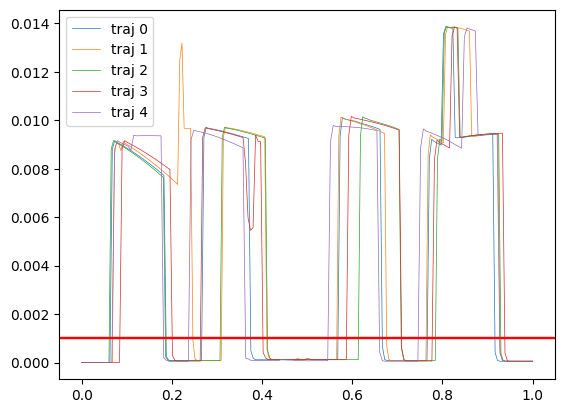

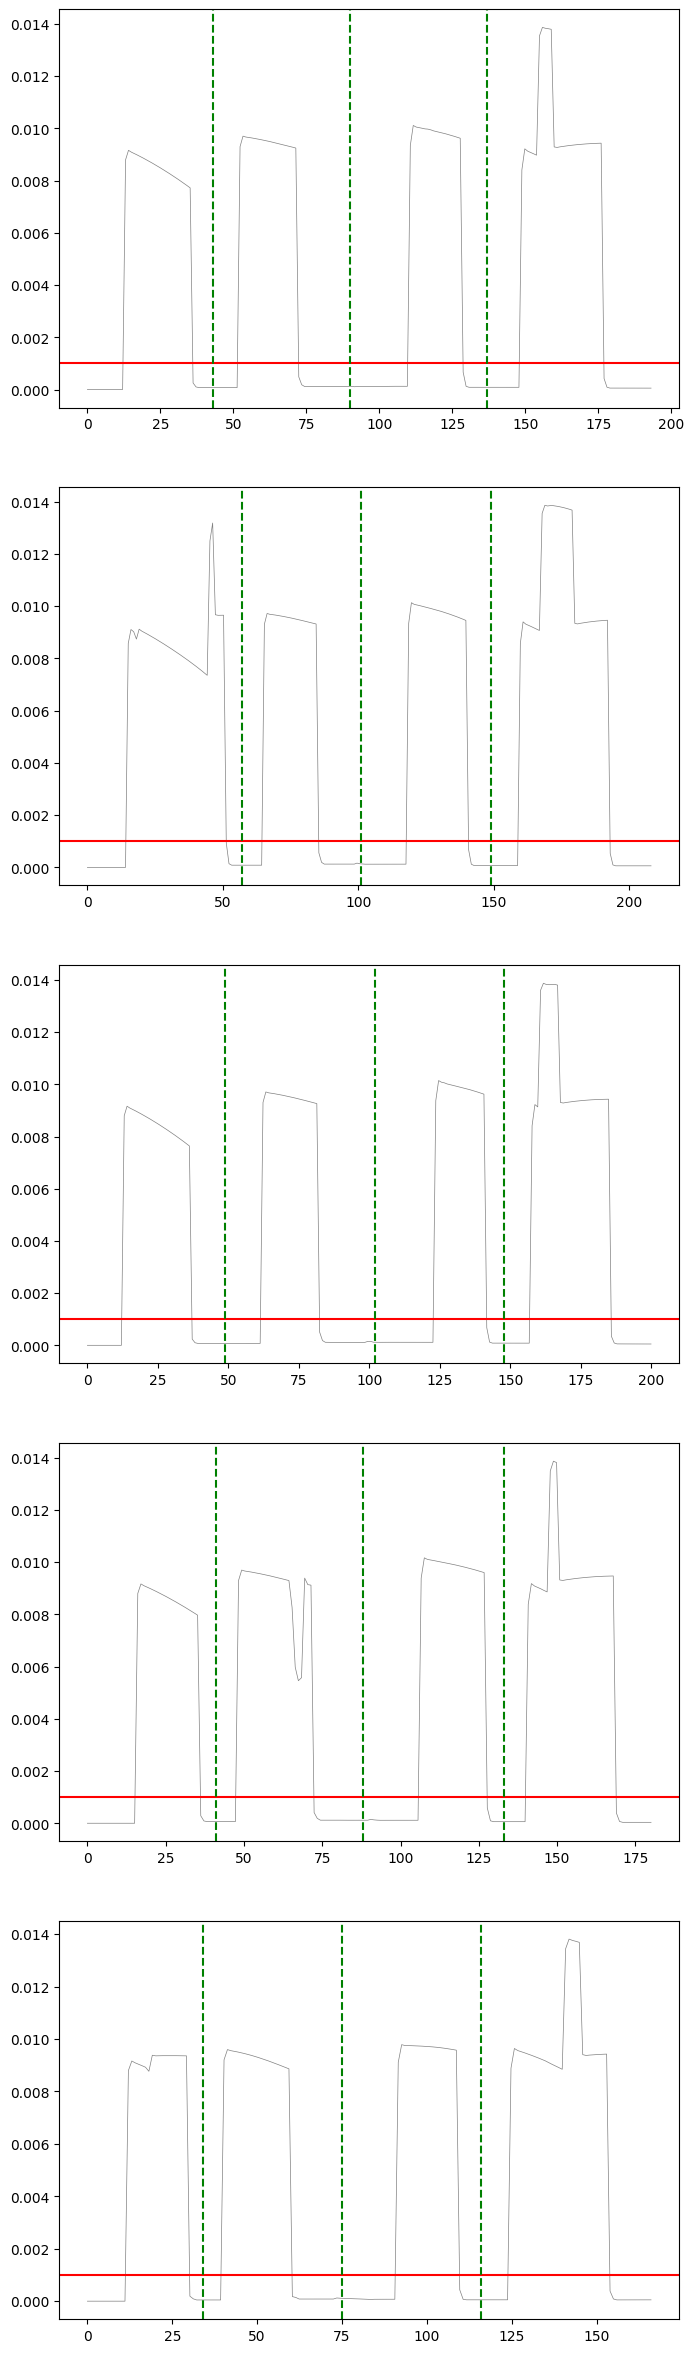

2025-08-06 01:09:06.042 | INFO     |  Creating segement of demos.
2025-08-06 01:09:06.060 | INFO     |  Subsampling to length 53 using strategy mean-length.
2025-08-06 01:09:06.062 | INFO     |  Creating segement of demos.
2025-08-06 01:09:06.074 | INFO     |  Subsampling to length 55 using strategy mean-length.
2025-08-06 01:09:06.076 | INFO     |  Creating segement of demos.
2025-08-06 01:09:06.087 | INFO     |  Subsampling to length 54 using strategy mean-length.
2025-08-06 01:09:06.089 | INFO     |  Creating segement of demos.
2025-08-06 01:09:06.101 | INFO     |  Subsampling to length 61 using strategy mean-length.
2025-08-06 01:09:06.103 | INFO     |  ... created 4 segments
2025-08-06 01:09:06.103 | INFO     |    Fitting candidate frame 1/10
2025-08-06 01:09:06.104 | INFO     |    Creating partial frame view of demos.
2025-08-06 01:09:06.113 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-06 01:09:06.113 | INFO     |    Changing number of components to 3
2025-08-06 01:09:

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:06.568 | INFO     |    Fitting candidate frame 2/10
2025-08-06 01:09:06.569 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:06.896 | INFO     |    Fitting candidate frame 3/10
2025-08-06 01:09:06.897 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:07.220 | INFO     |    Fitting candidate frame 4/10
2025-08-06 01:09:07.221 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:07.492 | INFO     |    Fitting candidate frame 5/10
2025-08-06 01:09:07.493 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:07.875 | INFO     |    Fitting candidate frame 6/10
2025-08-06 01:09:07.876 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:08.249 | INFO     |    Fitting candidate frame 7/10
2025-08-06 01:09:08.249 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:08.549 | INFO     |    Fitting candidate frame 8/10
2025-08-06 01:09:08.550 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:08.859 | INFO     |    Fitting candidate frame 9/10
2025-08-06 01:09:08.860 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:09.345 | INFO     |    Fitting candidate frame 10/10
2025-08-06 01:09:09.347 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:09.654 | INFO     |  ee_init    score (rel):     -0 (0.237)
2025-08-06 01:09:09.654 | INFO     |  obj000     score (rel):     -0 (0.237)
2025-08-06 01:09:09.655 | INFO     |  obj001     score (rel):     -0 (0.237)
2025-08-06 01:09:09.655 | INFO     |  obj002     score (rel):     -0 (0.237)
2025-08-06 01:09:09.655 | INFO     |  obj003     score (rel):     -0 (0.237)
2025-08-06 01:09:09.655 | INFO     |  obj004     score (rel):     -0 (0.237)
2025-08-06 01:09:09.655 | INFO     |  obj005     score (rel):     -0 (0.237)
2025-08-06 01:09:09.655 | INFO     |  obj006     score (rel):     -0 (0.005)
2025-08-06 01:09:09.655 | INFO     |  obj007     score (rel):     -0 (0.003)
2025-08-06 01:09:09.655 | INFO     |  obj008     score (rel):     -1 (1.000)
2025-08-06 01:09:09.657 | INFO     |  Creating partial frame view of demos.
2025-08-06 01:09:09.660 | INFO     |    Fitting candidate frame 1/10
2025-08-06 01:09:09.660 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:10.151 | INFO     |    Fitting candidate frame 2/10
2025-08-06 01:09:10.157 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:10.696 | INFO     |    Fitting candidate frame 3/10
2025-08-06 01:09:10.697 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:11.187 | INFO     |    Fitting candidate frame 4/10
2025-08-06 01:09:11.188 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:11.659 | INFO     |    Fitting candidate frame 5/10
2025-08-06 01:09:11.659 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:12.138 | INFO     |    Fitting candidate frame 6/10
2025-08-06 01:09:12.139 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:12.568 | INFO     |    Fitting candidate frame 7/10
2025-08-06 01:09:12.569 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:13.064 | INFO     |    Fitting candidate frame 8/10
2025-08-06 01:09:13.065 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:13.476 | INFO     |    Fitting candidate frame 9/10
2025-08-06 01:09:13.477 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:13.864 | INFO     |    Fitting candidate frame 10/10
2025-08-06 01:09:13.864 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:14.310 | INFO     |  ee_init    score (rel):     -0 (0.105)
2025-08-06 01:09:14.311 | INFO     |  obj000     score (rel):     -0 (0.105)
2025-08-06 01:09:14.311 | INFO     |  obj001     score (rel):     -0 (0.105)
2025-08-06 01:09:14.311 | INFO     |  obj002     score (rel):     -0 (0.105)
2025-08-06 01:09:14.311 | INFO     |  obj003     score (rel):     -0 (0.105)
2025-08-06 01:09:14.311 | INFO     |  obj004     score (rel):     -0 (0.105)
2025-08-06 01:09:14.311 | INFO     |  obj005     score (rel):     -0 (0.105)
2025-08-06 01:09:14.311 | INFO     |  obj006     score (rel):     -0 (0.004)
2025-08-06 01:09:14.312 | INFO     |  obj007     score (rel):     -0 (0.002)
2025-08-06 01:09:14.313 | INFO     |  Creating partial frame view of demos.
2025-08-06 01:09:14.317 | INFO     |    Fitting candidate frame 1/10
2025-08-06 01:09:14.317 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:14.622 | INFO     |    Fitting candidate frame 2/10
2025-08-06 01:09:14.623 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:14.997 | INFO     |    Fitting candidate frame 3/10
2025-08-06 01:09:14.998 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:15.352 | INFO     |    Fitting candidate frame 4/10
2025-08-06 01:09:15.354 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:15.716 | INFO     |    Fitting candidate frame 5/10
2025-08-06 01:09:15.720 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:16.193 | INFO     |    Fitting candidate frame 6/10
2025-08-06 01:09:16.194 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:16.702 | INFO     |    Fitting candidate frame 7/10
2025-08-06 01:09:16.703 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:17.046 | INFO     |    Fitting candidate frame 8/10
2025-08-06 01:09:17.047 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:17.468 | INFO     |    Fitting candidate frame 9/10
2025-08-06 01:09:17.469 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:17.835 | INFO     |    Fitting candidate frame 10/10
2025-08-06 01:09:17.836 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 01:09:18.248 | INFO     |  ee_init    score (rel):     -0 (0.123)
2025-08-06 01:09:18.249 | INFO     |  obj000     score (rel):     -0 (0.123)
2025-08-06 01:09:18.249 | INFO     |  obj001     score (rel):     -0 (0.123)
2025-08-06 01:09:18.249 | INFO     |  obj002     score (rel):     -0 (0.123)
2025-08-06 01:09:18.249 | INFO     |  obj003     score (rel):     -0 (0.123)
2025-08-06 01:09:18.249 | INFO     |  obj004     score (rel):     -0 (0.123)
2025-08-06 01:09:18.250 | INFO     |  obj005     score (rel):     -0 (0.123)
2025-08-06 01:09:18.251 | INFO     |  Creating partial frame view of demos.
2025-08-06 01:09:18.255 | INFO     |    Fitting candidate frame 1/10
2025-08-06 01:09:18.255 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:18.607 | INFO     |    Fitting candidate frame 2/10
2025-08-06 01:09:18.607 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:19.092 | INFO     |    Fitting candidate frame 3/10
2025-08-06 01:09:19.093 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:19.593 | INFO     |    Fitting candidate frame 4/10
2025-08-06 01:09:19.594 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:20.029 | INFO     |    Fitting candidate frame 5/10
2025-08-06 01:09:20.030 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:20.420 | INFO     |    Fitting candidate frame 6/10
2025-08-06 01:09:20.422 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:20.767 | INFO     |    Fitting candidate frame 7/10
2025-08-06 01:09:20.768 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:21.261 | INFO     |    Fitting candidate frame 8/10
2025-08-06 01:09:21.262 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:21.659 | INFO     |    Fitting candidate frame 9/10
2025-08-06 01:09:21.660 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:21.986 | INFO     |    Fitting candidate frame 10/10
2025-08-06 01:09:21.987 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:22.331 | INFO     |  ee_init    score (rel):     -0 (0.281)
2025-08-06 01:09:22.331 | INFO     |  obj000     score (rel):     -0 (0.281)
2025-08-06 01:09:22.332 | INFO     |  obj001     score (rel):     -0 (0.281)
2025-08-06 01:09:22.332 | INFO     |  obj002     score (rel):     -0 (0.281)
2025-08-06 01:09:22.332 | INFO     |  obj003     score (rel):     -0 (0.281)
2025-08-06 01:09:22.332 | INFO     |  obj004     score (rel):     -0 (0.281)
2025-08-06 01:09:22.332 | INFO     |  obj005     score (rel):     -0 (0.281)
2025-08-06 01:09:22.332 | INFO     |  obj006     score (rel):     -0 (0.014)
2025-08-06 01:09:22.332 | INFO     |  obj007     score (rel):     -0 (0.006)
2025-08-06 01:09:22.335 | INFO     |  Creating partial frame view of demos.
2025-08-06 01:09:22.337 | INFO     |  Segmented trajs into 4 segments
2025-08-06 01:09:22.370 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142098 -0.142098 -

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[3.06e+08, 3.06e+08, 2.98e+08, 2.82e+08, 2.59e+08, 2.32e+08,
          2.01e+08, 1.70e+08, 1.40e+08, 1.12e+08, 8.67e+07, 6.54e+07,
          4.80e+07, 3.43e+07, 2.23e+07, 1.36e+07, 7.76e+06, 4.17e+06,
          2.10e+06, 9.98e+05, 4.45e+05, 1.87e+05, 7.38e+04, 2.75e+04,
          9.64e+03, 3.19e+03, 9.94e+02, 4.78e+02, 1.37e+02, 3.70e+01,
          9.45e+00, 2.28e+00, 5.21e-01, 1.13e-01, 2.31e-02, 4.48e-03,
          8.25e-04, 1.44e-04, 4.98e-05, 1.73e-05, 5.80e-06, 1.90e-06,
          6.03e-07, 1.86e-07, 5.56e-08, 1.61e-08, 4.56e-09, 1.25e-09,
          3.34e-10, 8.65e-11, 2.18e-11, 5.35e-12, 1.28e-12, 1.68e+08,
          1.68e+08, 1.64e+08, 1.55e+08, 1.42e+08, 1.27e+08, 1.10e+08,
          9.33e+07, 7.66e+07, 6.12e+07, 4.75e+07, 3.59e+07, 2.63e+07,
          1.40e+07, 4.46e+06, 4.09e+06, 3.64e+06, 3.03e+06, 2.38e+06,
          2.06e+06, 1.37e+06, 8.62e+05, 5.25e+05, 2.82e+05, 1.43e+05,
          6.83e+04, 3.08e+04, 1.12e+04, 4.35e+03, 1.60e+03, 4.24e+02,
          1.35e+02, 

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-06 01:09:23.994 | INFO     |  Did not specify time_based, deciding automatically.


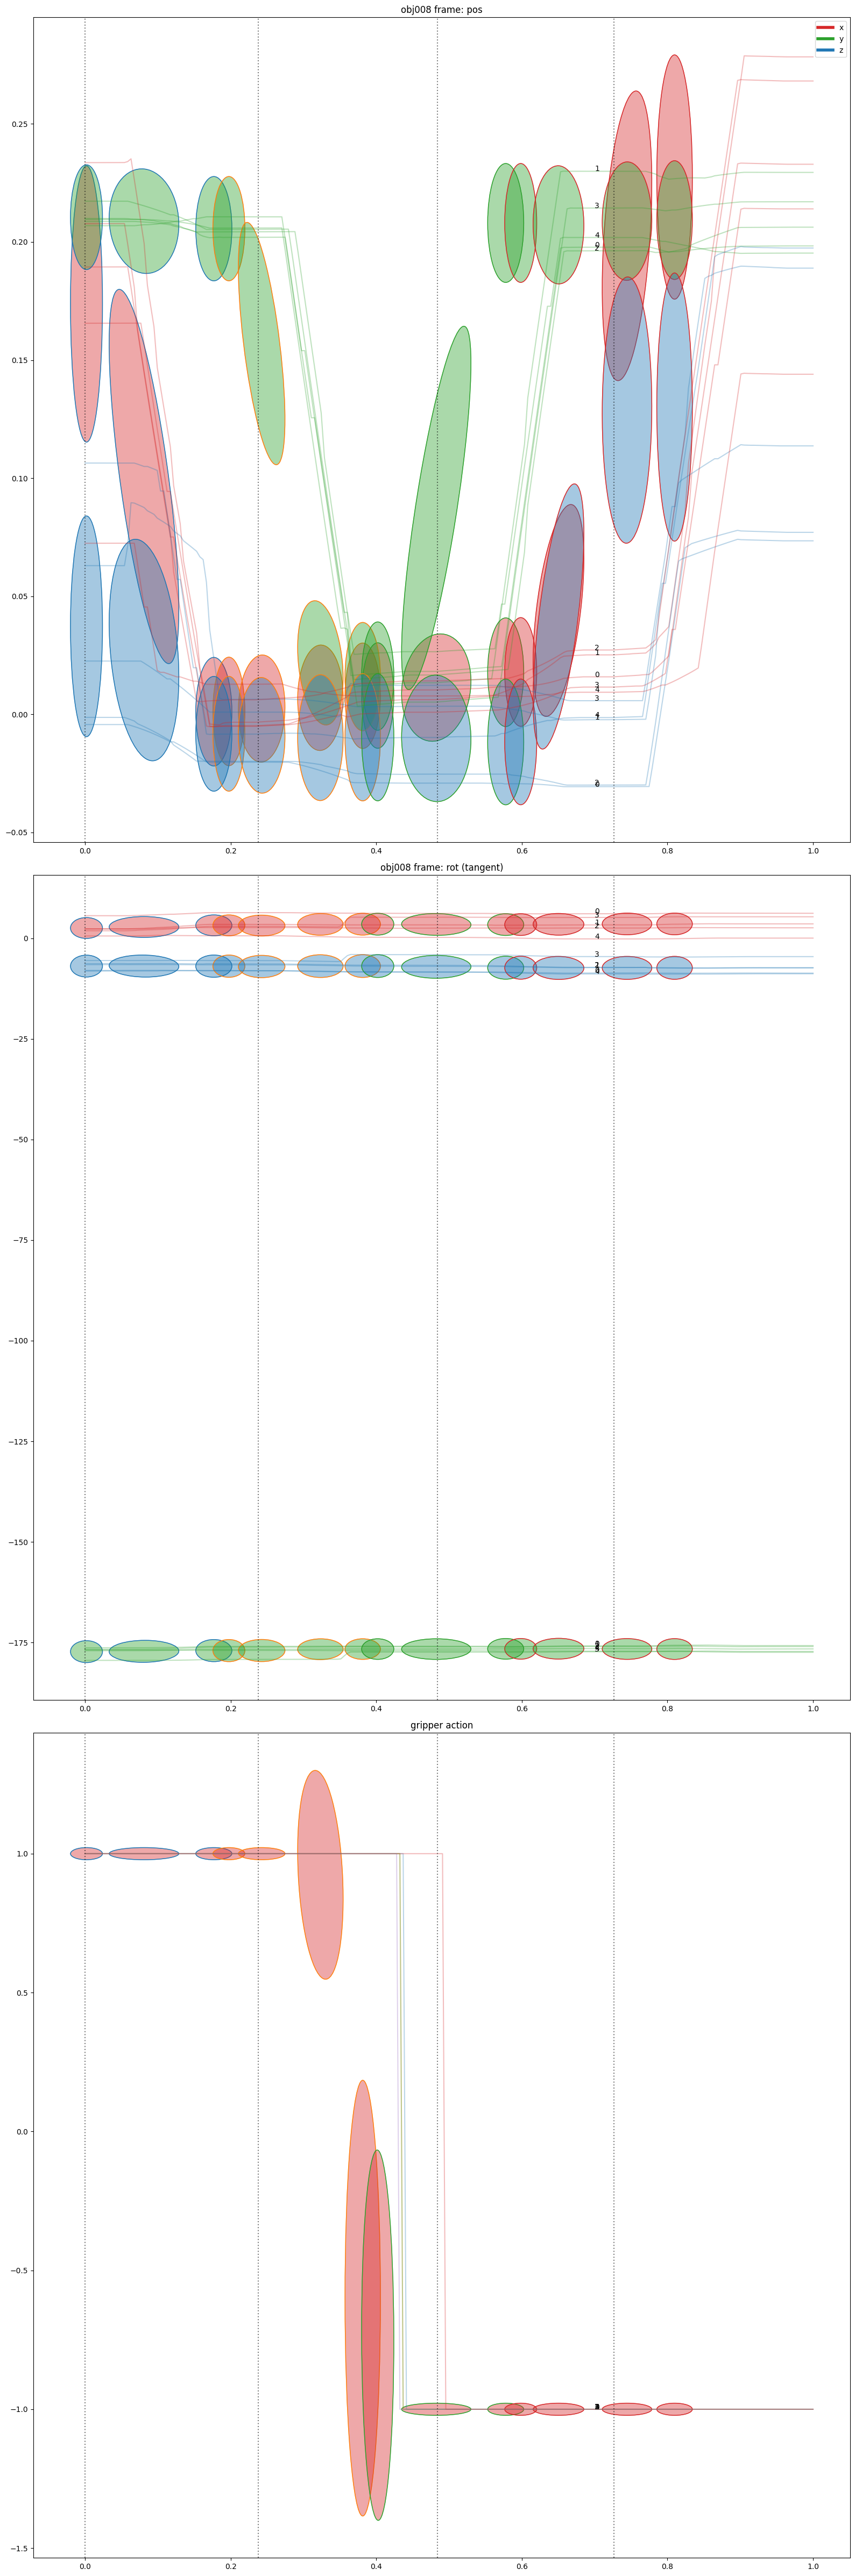

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-06 01:09:27.765 | INFO     |  Fitting AutoTPGMM
2025-08-06 01:09:27.765 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 01:09:27.781 | INFO     |  HMM EM ...
2025-08-06 01:09:27.792 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-06 01:09:27.847 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-06 01:09:30.712 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 9.96e-001, 9.72e-001, 8.86e-001, 6.90e-001,
          4.16e-001, 1.76e-001, 4.44e-002, 6.12e-003, 4.30e-004, 1.46e-005,
          2.26e-007, 1.55e-009, 4.46e-012, 5.24e-015, 2.40e-018, 4.16e-022,
          2.62e-026, 5.78e-031, 4.31e-036, 1.57e-041, 1.83e-047, 6.56e-054,
          6.52e-061, 1.37e-068, 4.51e-077, 2.01e-086, 1.21e-096, 1.02e-107,
          1.30e-119, 2.77e-132, 1.65e-145, 2.79e-159, 1.33e-173, 1.78e-188,
          6.60e-204, 6.81e-220, 1.92e-236, 1.47e-253, 3.05e-271, 1.70e-289,
          2.53e-308, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.98e-001,
          9.91e-001, 9.62e-001, 8.85e-001, 7.32e-001, 5.15e-001, 2.89e-001,
          1.18e-001, 3.18e-002, 6.20e-003, 8.35e-004, 7.45e-005, 4.19e-006,
          1.25e-007, 2.14e-009, 2.01e-011, 8.22e-014, 1.68e-016, 1.64e-019,
          7.

2025-08-06 01:09:47.673 | INFO     |  Did not specify time_based, deciding automatically.


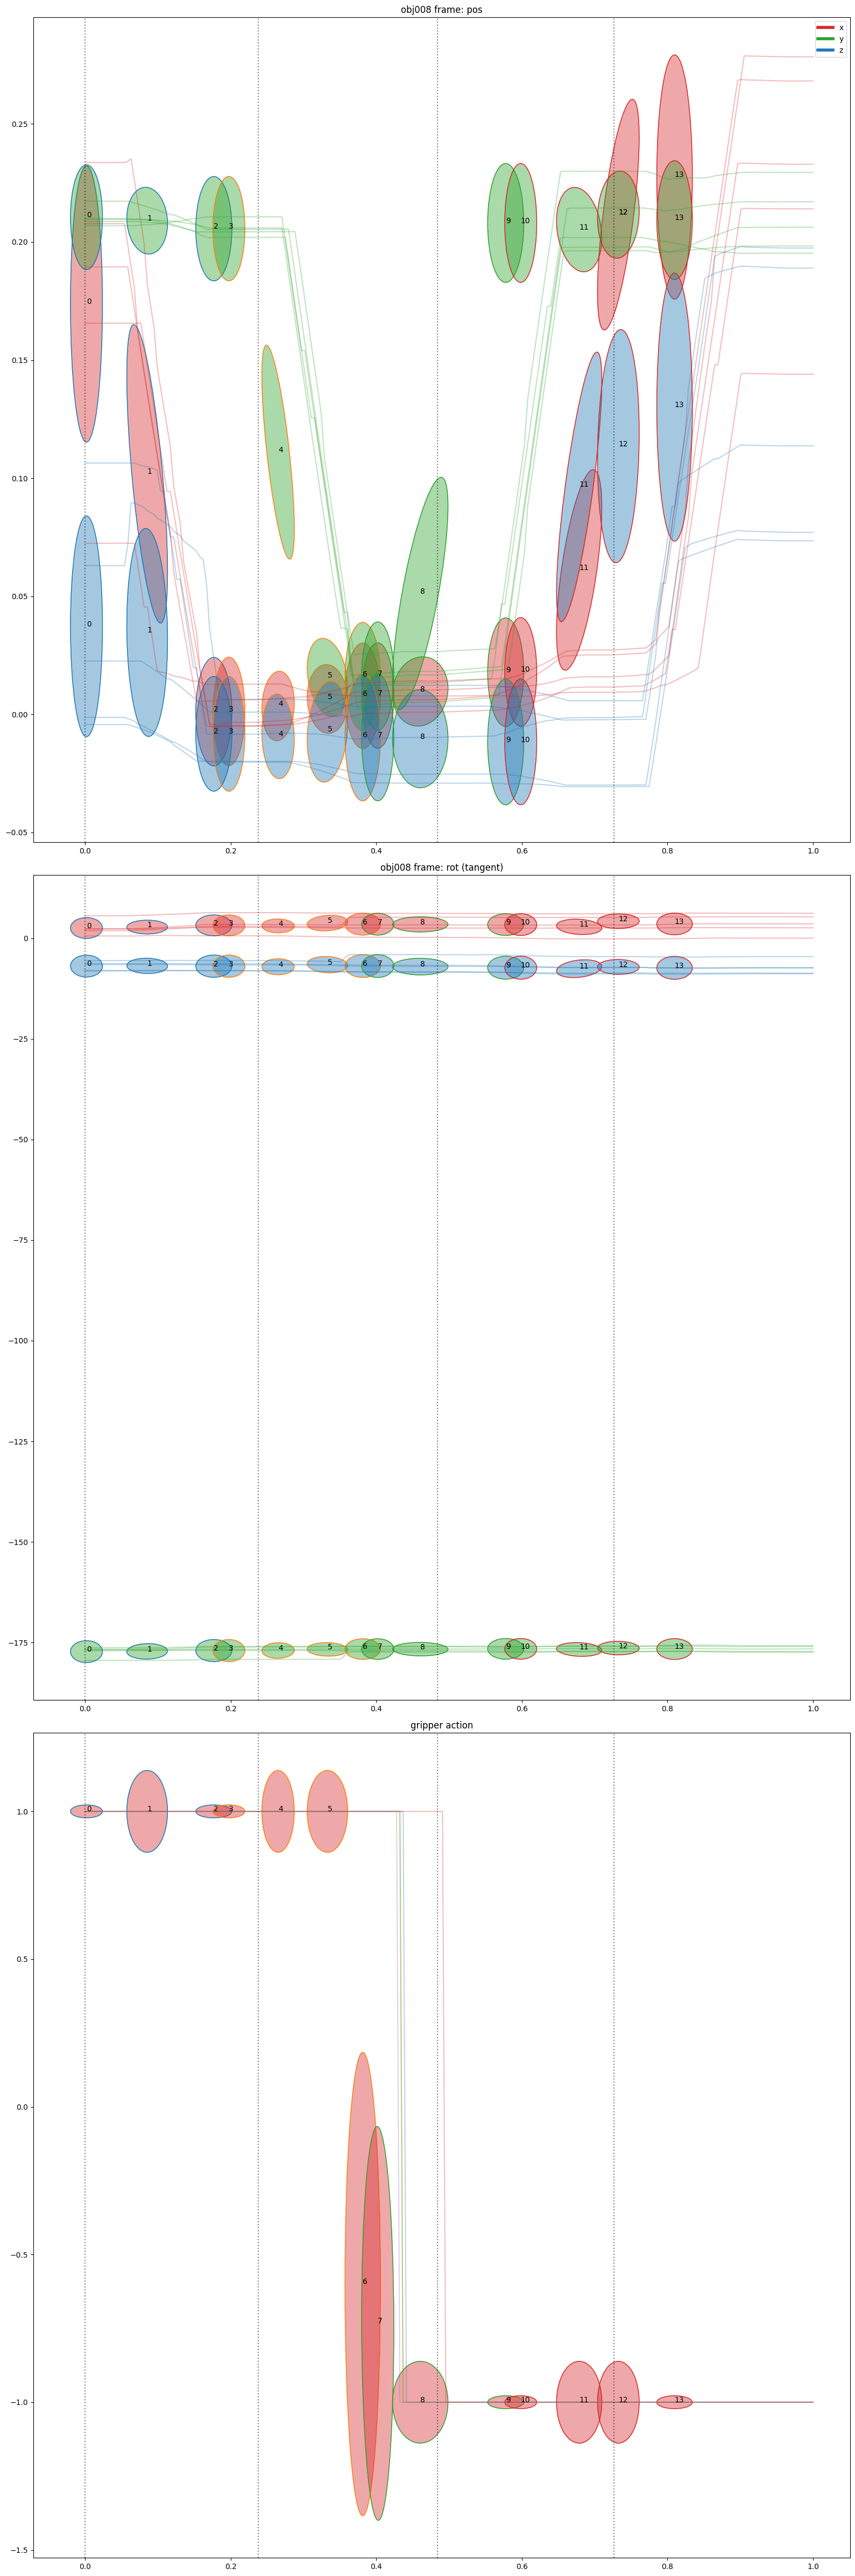

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

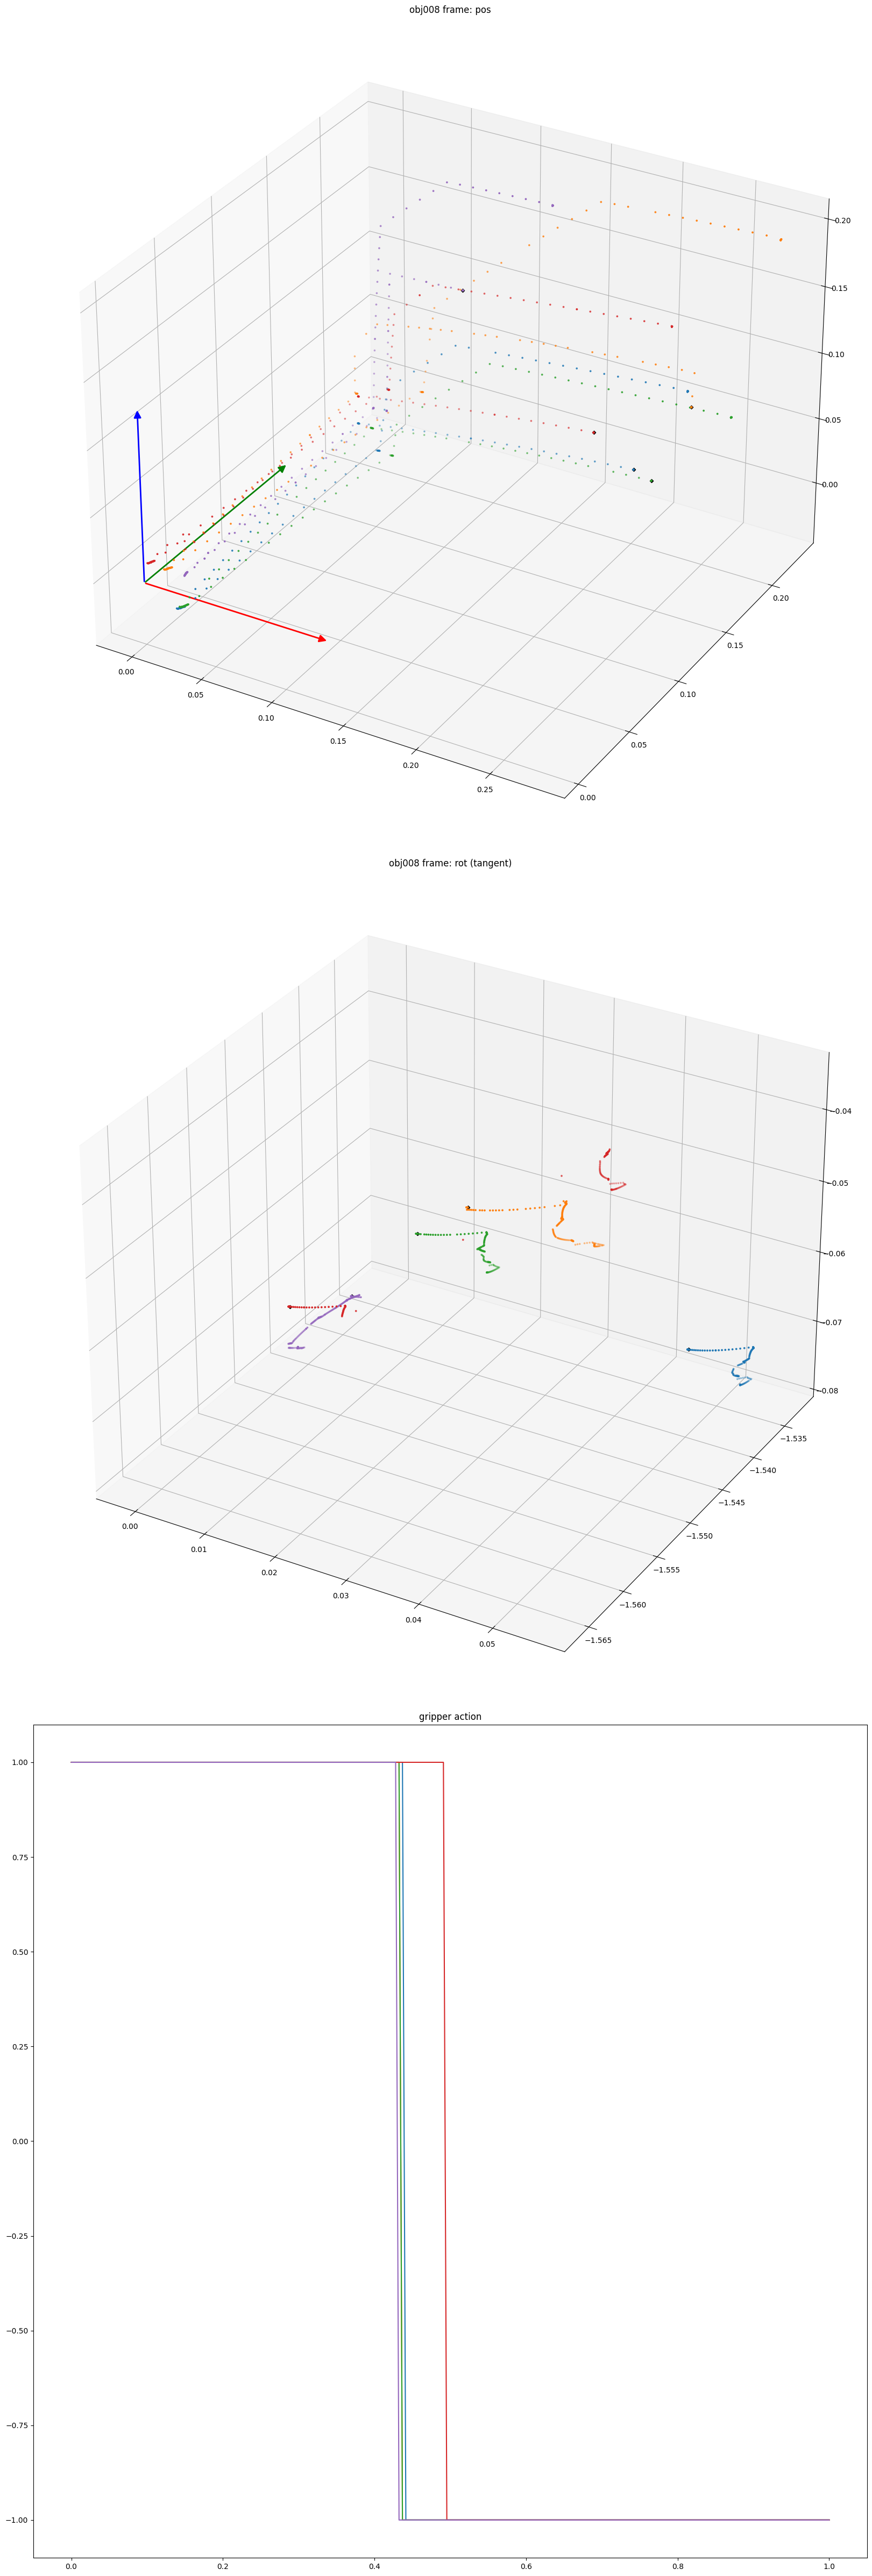

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

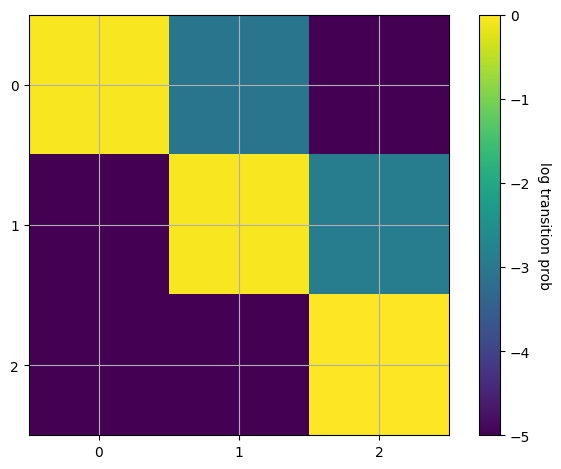

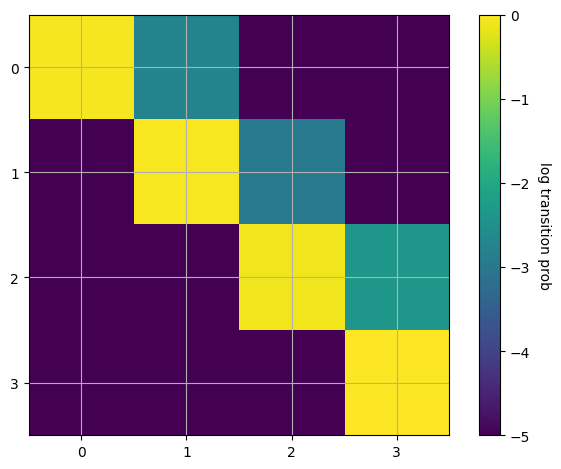

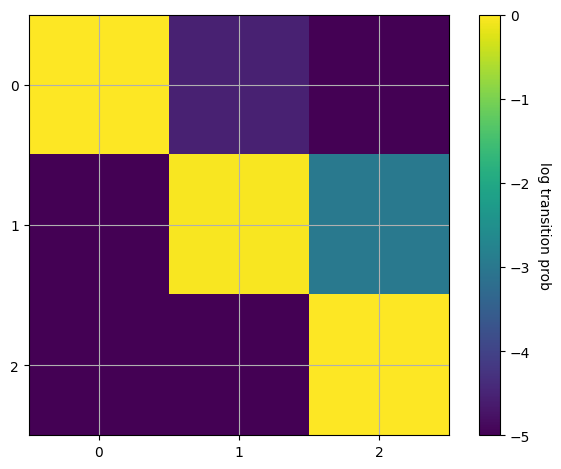

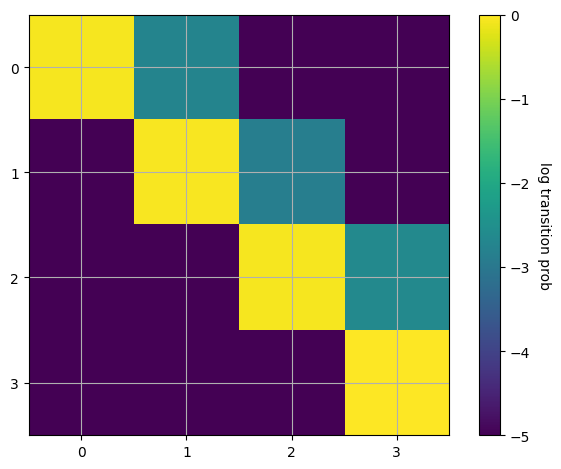

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-06 01:09:57.232 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-06 01:09:57.616 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-06 01:09:57.736 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-06 01:09:57.737 | INFO     |  Creating partial frame view of demos.
2025-08-06 01:09:57.807 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-06 01:09:57.899 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-06 01:09:58.040 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-06 01:09:58.194 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-06 01:09:58.357 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

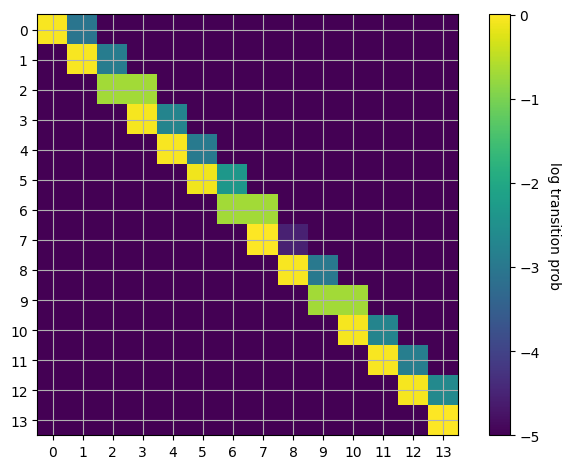

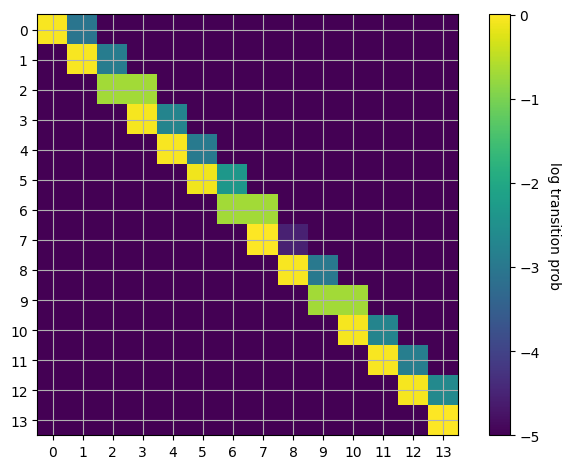

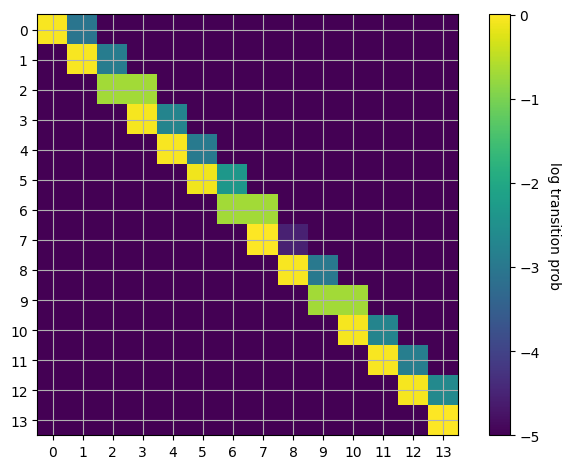

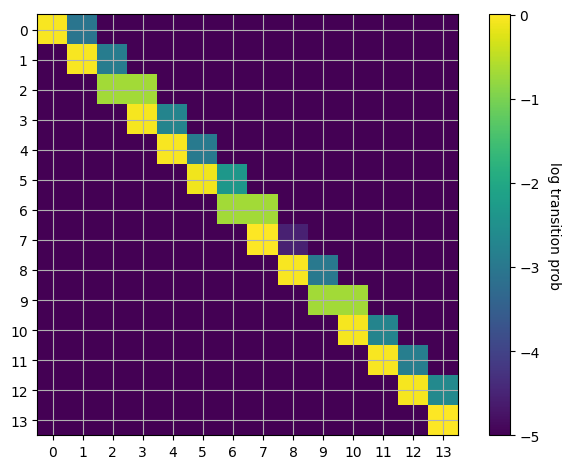

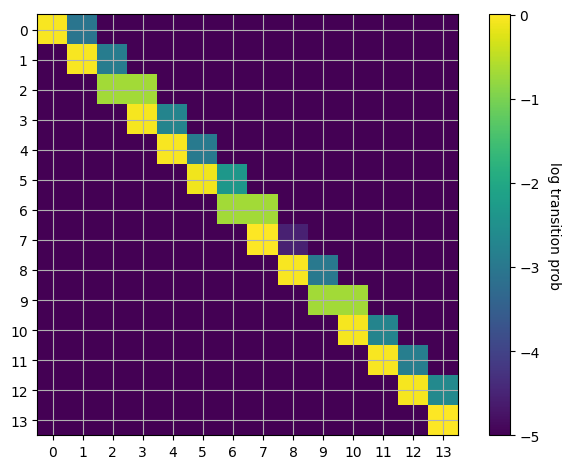

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-06 01:10:21.784 | INFO     |  Taking frame origins from demos.


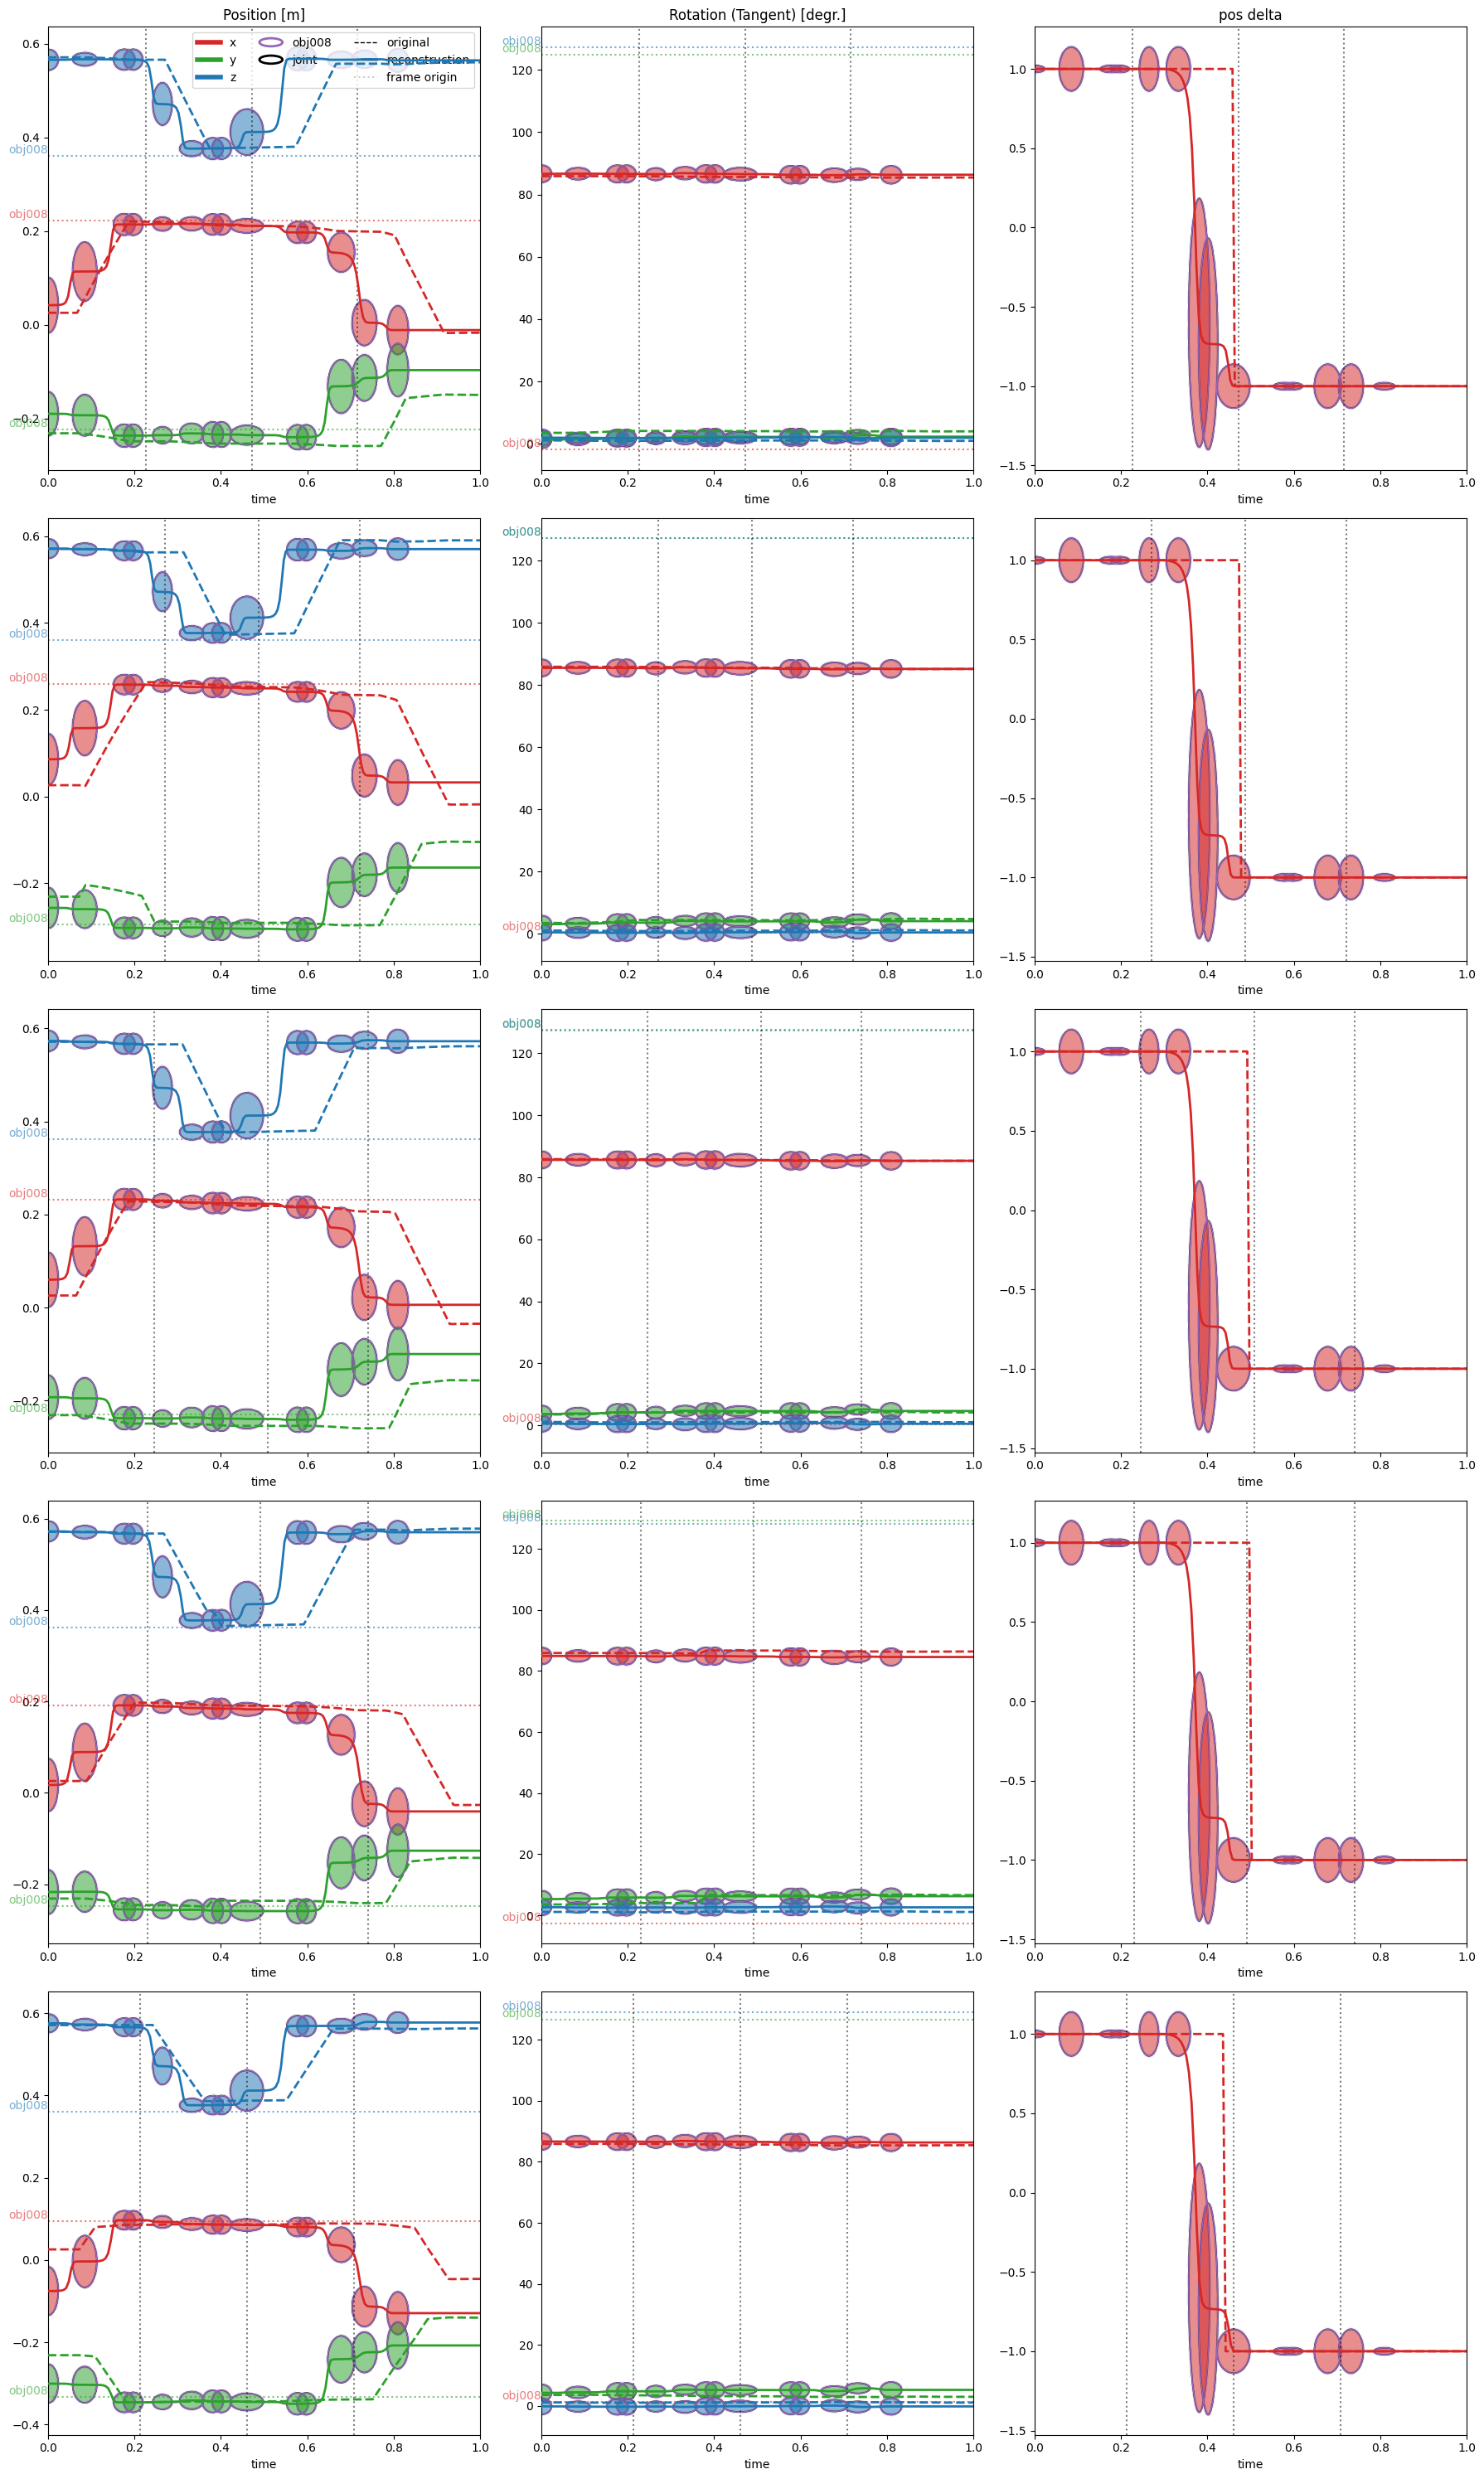

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range

: 